## 1. Gerekli Kütüphanelerin Kurulumu ve Yüklenmesi

In [18]:
pip install tensorflow pandas matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import glob
import pandas as pd

# 2. Veri Setinin Yüklenmesi ve Önişleme

**2.1. Veri Yükleme ve Pandas DataFrame Oluşturma**

In [22]:
# Veri seti klasör yolunu tanımla
dataset_dir = "//kaggle//input//a-large-scale-fish-dataset//Fish_Dataset//Fish_Dataset"

# Tüm resim dosyalarını ve etiketlerini listele
filepaths = []
labels = []

# Ana balık türü klasörlerini gez
for fish_type in os.listdir(dataset_dir):    
    fish_type_path = os.path.join(dataset_dir, fish_type)
    
    # Sadece klasörleri işle
    if os.path.isdir(fish_type_path):
        # Her balık türü için alt klasörleri gez
        for folder in os.listdir(fish_type_path):
            folder_path = os.path.join(fish_type_path, folder)
            
            # Sadece resimlerin bulunduğu klasörleri kontrol et
            if os.path.isdir(folder_path):  # Bu kontrol, klasör olup olmadığını doğrular
                for file in glob.glob(os.path.join(folder_path, "*.png")):
                    filepaths.append(file)
                    labels.append(fish_type)  # Balık türü ana klasör adı

# DataFrame oluşturma
df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})


# DataFrame'i inceleme
print(df.head())
print(f"Toplam resim sayısı: {len(filepaths)}")
print(f"Toplam etiket sayısı: {len(labels)}")


                                            filepath            label
0  //kaggle//input//a-large-scale-fish-dataset//F...  Hourse Mackerel
1  //kaggle//input//a-large-scale-fish-dataset//F...  Hourse Mackerel
2  //kaggle//input//a-large-scale-fish-dataset//F...  Hourse Mackerel
3  //kaggle//input//a-large-scale-fish-dataset//F...  Hourse Mackerel
4  //kaggle//input//a-large-scale-fish-dataset//F...  Hourse Mackerel
Toplam resim sayısı: 18000
Toplam etiket sayısı: 18000


**2.2. Veri Setinin İncelenmesi**

In [23]:
# Veri setinde kaç farklı sınıf olduğunu gör
print(df['label'].value_counts())

# Veri setindeki eksik verileri kontrol et
print(df.isnull().sum())

# Veri setindeki örnek resimlerin boyutlarını ve formatını incele
print(df['filepath'][0])


label
Hourse Mackerel       2000
Black Sea Sprat       2000
Sea Bass              2000
Red Mullet            2000
Trout                 2000
Striped Red Mullet    2000
Shrimp                2000
Gilt-Head Bream       2000
Red Sea Bream         2000
Name: count, dtype: int64
filepath    0
label       0
dtype: int64
//kaggle//input//a-large-scale-fish-dataset//Fish_Dataset//Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00929.png


# 3. Veri Setinin Eğitim ve Test Setlerine Bölünmesi

In [24]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

print(f"Eğitim seti boyutu: {len(train_df)}")
print(f"Test seti boyutu: {len(test_df)}")


Eğitim seti boyutu: 14400
Test seti boyutu: 3600


# 4. Resimlerin Ön İşlenmesi ve Veri Artırımı


In [25]:
# Eğitim ve test verileri için ImageDataGenerator tanımlama
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Veriyi ImageDataGenerator ile yükleme
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='filepath', 
                                                    y_col='label', 
                                                    target_size=(150, 150), 
                                                    batch_size=32, 
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                  x_col='filepath', 
                                                  y_col='label', 
                                                  target_size=(150, 150), 
                                                  batch_size=32, 
                                                  class_mode='categorical')


Found 14400 validated image filenames belonging to 9 classes.
Found 3600 validated image filenames belonging to 9 classes.


# 5. Modelin Oluşturulması (ANN)

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(150, 150, 3)),  # 150x150 px, RGB
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')  # 9 sınıf için
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     8,640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,648,969 (32.99 MB)

 Trainable params: 8,648,969 (32.99 MB)

 Non-trainable params: 0 (0.00 B)

# 6. Modelin Eğitilmesi

In [29]:
history = model.fit(train_generator, 
                    epochs=10, 
                    validation_data=test_generator)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


450/450 ━━━━━━━━━━━━━━━━━━━━ 447s 970ms/step - accuracy: 0.1117 - loss: 3.5954 - val_accuracy: 0.1111 - val_loss: 2.1973
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 257s 564ms/step - accuracy: 0.1086 - loss: 2.2018 - val_accuracy: 0.1108 - val_loss: 2.1972
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 248s 543ms/step - accuracy: 0.1155 - loss: 2.2013 - val_accuracy: 0.1111 - val_loss: 2.1972
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 246s 539ms/step - accuracy: 0.1088 - loss: 2.1991 - val_accuracy: 0.1111 - val_loss: 2.1972
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 249s 547ms/step - accuracy: 0.1072 - loss: 2.1974 - val_accuracy: 0.1111 - val_loss: 2.1972
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 263s 578ms/step - accuracy: 0.1114 - loss: 2.1979 - val_accuracy: 0.1111 - val_loss: 2.1972
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 256s 562ms/step - accuracy: 0.1066 - loss: 2.1981 - val_accuracy: 0.1111 - val_loss: 2.1972
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 251s 551ms/step - accuracy: 0.0990 - loss: 2.19

# 7. Model Sonuçlarının Grafiklerle İncelenmesi

**1. Loss ve Accuracy Fonksiyonlarının Grafikle Gösterilmesi**

Kayıp Fonksiyonu Grafiği: Bu grafik, modelin eğitim ve doğrulama süreçlerindeki kayıp fonksiyonunun nasıl değiştiğini gösterir.

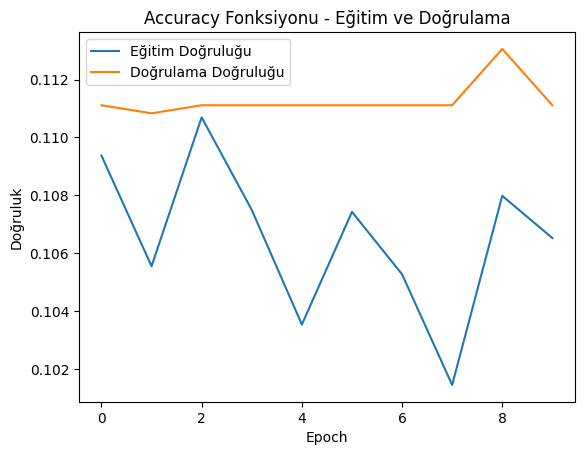

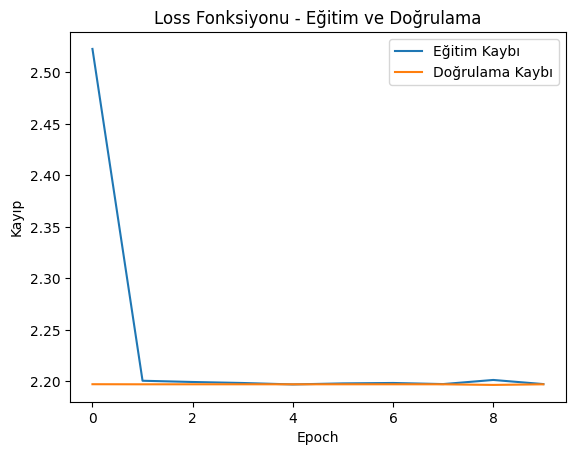

In [30]:
# Eğitim süreci sonuçlarını görselleştirme
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Accuracy Fonksiyonu - Eğitim ve Doğrulama')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

# Kayıp fonksiyonu (Loss) için grafik
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Loss Fonksiyonu - Eğitim ve Doğrulama')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()


**2. Confusion Matrix (Karışıklık Matrisi) ve Classification Report Oluşturma**

*a. Test Verileri İçin Tahminler*

In [31]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Test seti için tahminler yap
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)  # Tahmin edilen sınıflar

# Gerçek etiketleri elde et
y_true = test_generator.classes

# Sınıf isimlerini elde et
class_labels = list(test_generator.class_indices.keys())


113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 243ms/step


*b. Confusion Matrix (Karışıklık Matrisi)*

Confusion Matrix: Bu matris, modelin hangi sınıfları doğru veya yanlış tahmin ettiğini gösterir.

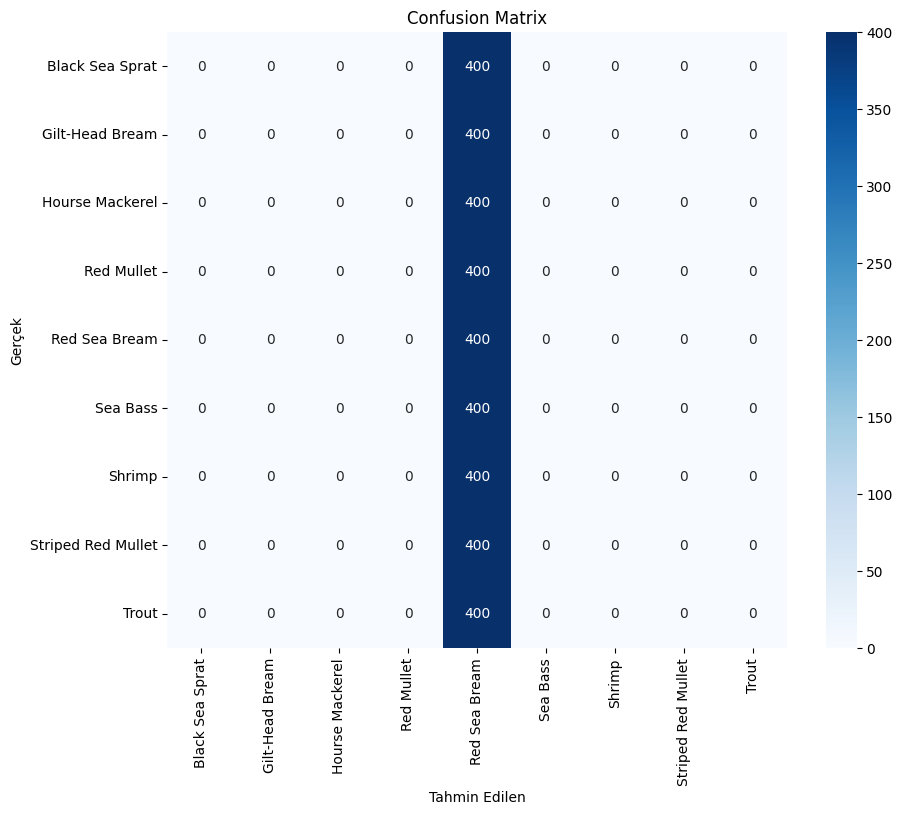

In [32]:
# Confusion matrix oluştur
cm = confusion_matrix(y_true, y_pred)

# Confusion matrix'i görselleştir
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()


*c. Classification Report (Sınıflandırma Raporu)*

Classification Report: Precision, recall, F1-score gibi önemli performans metriklerini sınıf bazında sunar.

In [33]:
# Classification report oluştur
report = classification_report(y_true, y_pred, target_names=class_labels)

# Raporu yazdır
print('Classification Report:')
print(report)


Classification Report:
                    precision    recall  f1-score   support

   Black Sea Sprat       0.00      0.00      0.00       400
   Gilt-Head Bream       0.00      0.00      0.00       400
   Hourse Mackerel       0.00      0.00      0.00       400
        Red Mullet       0.00      0.00      0.00       400
     Red Sea Bream       0.11      1.00      0.20       400
          Sea Bass       0.00      0.00      0.00       400
            Shrimp       0.00      0.00      0.00       400
Striped Red Mullet       0.00      0.00      0.00       400
             Trout       0.00      0.00      0.00       400

          accuracy                           0.11      3600
         macro avg       0.01      0.11      0.02      3600
      weighted avg       0.01      0.11      0.02      3600



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 8. Sonuçların Değerlendirilmesi